In [97]:
from pyspark.sql import SparkSession
import os
from pyspark.sql.types import *
from pyspark.sql.functions import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
spark = SparkSession\
    .builder\
    .appName("Airline")\
    .config("spark.hadoop.fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")\
    .getOrCreate()

In [99]:
from IPython.core.display import HTML
HTML('<a href="http://spark-{}.{}">Spark UI</a>'.format(os.getenv("CDSW_ENGINE_ID"),os.getenv("CDSW_DOMAIN")))

In [100]:
schema = StructType([StructField("FL_DATE", TimestampType(), True),
StructField("OP_CARRIER", StringType(), True),
StructField("OP_CARRIER_FL_NUM", StringType(), True),
StructField("ORIGIN", StringType(), True),
StructField("DEST", StringType(), True),
StructField("CRS_DEP_TIME", StringType(), True),
StructField("DEP_TIME", StringType(), True),
StructField("DEP_DELAY", DoubleType(), True),
StructField("TAXI_OUT", DoubleType(), True),
StructField("WHEELS_OFF", StringType(), True),
StructField("WHEELS_ON", StringType(), True),
StructField("TAXI_IN", DoubleType(), True),
StructField("CRS_ARR_TIME", StringType(), True),
StructField("ARR_TIME", StringType(), True),
StructField("ARR_DELAY", DoubleType(), True),
StructField("CANCELLED", DoubleType(), True),
StructField("CANCELLATION_CODE", StringType(), True),
StructField("DIVERTED", DoubleType(), True),
StructField("CRS_ELAPSED_TIME", DoubleType(), True),
StructField("ACTUAL_ELAPSED_TIME", DoubleType(), True),
StructField("AIR_TIME", DoubleType(), True),
StructField("DISTANCE", DoubleType(), True),
StructField("CARRIER_DELAY", DoubleType(), True),
StructField("WEATHER_DELAY", DoubleType(), True),
StructField("NAS_DELAY", DoubleType(), True),
StructField("SECURITY_DELAY", DoubleType(), True),
StructField("LATE_AIRCRAFT_DELAY", DoubleType(), True)])


flight_df = spark.read.csv(
  path="s3a://ml-field/demo/flight-analysis/data/airlines_csv/*",header=True,
  schema=schema)

flight_df.persist()

DataFrame[FL_DATE: timestamp, OP_CARRIER: string, OP_CARRIER_FL_NUM: string, ORIGIN: string, DEST: string, CRS_DEP_TIME: string, DEP_TIME: string, DEP_DELAY: double, TAXI_OUT: double, WHEELS_OFF: string, WHEELS_ON: string, TAXI_IN: double, CRS_ARR_TIME: string, ARR_TIME: string, ARR_DELAY: double, CANCELLED: double, CANCELLATION_CODE: string, DIVERTED: double, CRS_ELAPSED_TIME: double, ACTUAL_ELAPSED_TIME: double, AIR_TIME: double, DISTANCE: double, CARRIER_DELAY: double, WEATHER_DELAY: double, NAS_DELAY: double, SECURITY_DELAY: double, LATE_AIRCRAFT_DELAY: double]

In [101]:
cancel_by_carrier = flight_df\
  .filter("CANCELLED == 1")\
  .groupby("OP_CARRIER")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_delays')

  
flight_by_carrier = flight_df\
  .groupby("OP_CARRIER")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_total')

  
cancel_by_carrier_percent = flight_by_carrier\
  .join(
    cancel_by_carrier, 
    flight_by_carrier.OP_CARRIER == cancel_by_carrier.OP_CARRIER
  )
  
cancel_by_carrier_percent = cancel_by_carrier_percent\
  .withColumn(
    "delay_percent",(
      cancel_by_carrier_percent.count_delays/cancel_by_carrier_percent.count_total
    )*100
  )\
  .sort("delay_percent",ascending=False)\
  .toPandas()

display(cancel_by_carrier_percent.head(20))


OP_CARRIER  count_total OP_CARRIER  count_delays  delay_percent
0          OH       577060         OH         22623       3.920390
1          MQ      3216260         MQ        113693       3.534944
2          YX       316090         YX         10100       3.195292
3          EV      4726445         EV        137042       2.899473
4          XE      1105864         XE         27595       2.495334
5          9E      1066251         9E         25797       2.419412
6          YV      1063558         YV         22740       2.138106
7          NK       588574         NK         11511       1.955744
8          OO      6263052         OO        114445       1.827304
9          B6      2483969         B6         43906       1.767574
10         AA      6682161         AA        108555       1.624549
11         US      2657286         US         36711       1.381522
12         UA      4826658         UA         58635       1.214816
13         WN     12096540         WN        133587       1.104341
14         FL      1218389         FL         11732       0.962911
15         VX       389060         VX          3550       0.912456
16         CO       740498         CO          6142       0.829442
17         DL      7841880         DL         62966       0.802945
18         G4        96221         G4           769       0.799202
19         F9       903218         F9          7143       0.790839

In [102]:
# Plot number of flights per year

## TIP
## This is important, you can run spark.sql functions inside R  

flight_by_year = flight_df\
  .withColumn("year",year("FL_DATE"))\
  .groupby("year")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_total')
  
cancel_by_year = flight_df\
  .filter("CANCELLED == 1")\
  .withColumn("year_cancel",year("FL_DATE"))\
  .groupby("year_cancel")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'cancel_total')

cancel_by_year_percent = flight_by_year\
  .join(
    cancel_by_year, 
    flight_by_year.year == cancel_by_year.year_cancel
  )  
  
cancel_by_year_percent = cancel_by_year_percent\
  .withColumn(
    "delay_percent",(
      cancel_by_year_percent.cancel_total/cancel_by_year_percent.count_total
    )*100
  )\
  .sort("year",ascending=False)
  
cancel_by_year_percent_pd = cancel_by_year_percent.toPandas()


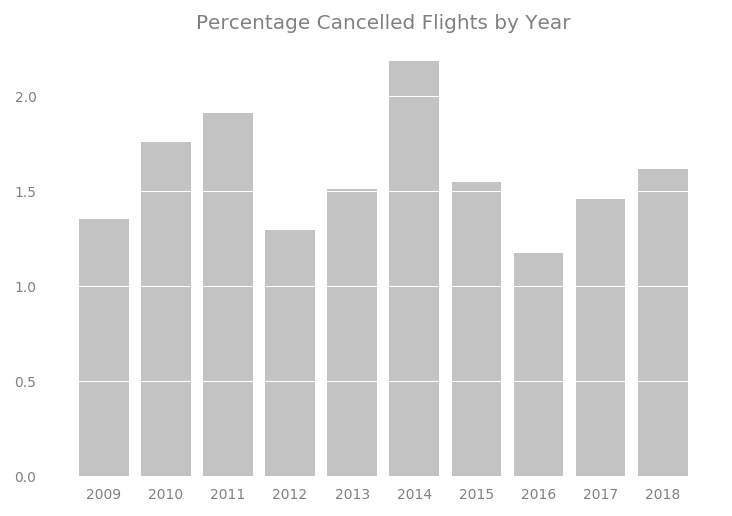

In [103]:
def plotter():
  sns.set_style("white",{'axes.axisbelow': False})
  plt.bar( 
    cancel_by_year_percent_pd.year, 
    cancel_by_year_percent_pd.delay_percent,
    align='center', 
    alpha=0.5,
    color='#888888',
  )
  plt.grid(color='#FFFFFF', linestyle='-', linewidth=0.5, axis='y')
  plt.title(
    'Percentage Cancelled Flights by Year',
    color='grey'
  )
  plt.xticks(
    cancel_by_year_percent_pd.year,
    color='grey'
  )
  plt.yticks(color='grey')
  sns.despine(left=True,bottom=True)
plotter()



## Plot number of flights per week

In [104]:
flight_by_week = flight_df\
  .withColumn("week",weekofyear("FL_DATE"))\
  .groupby("week")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'count_total')
  
cancel_by_week = flight_df\
  .filter("CANCELLED == 1")\
  .withColumn("week_cancel",weekofyear("FL_DATE"))\
  .groupby("week_cancel")\
  .count()\
  .sort("count",ascending=False)\
  .withColumnRenamed('count', 'cancel_total')

cancel_by_week_percent = flight_by_week\
  .join(
    cancel_by_week, 
    flight_by_week.week == cancel_by_week.week_cancel
  )  
  
cancel_by_week_percent = cancel_by_week_percent\
  .withColumn(
    "delay_percent",(
      cancel_by_week_percent.cancel_total/cancel_by_week_percent.count_total
    )*100
  )\
  .sort("week",ascending=False)
  
cancel_by_week_percent_pd = cancel_by_week_percent.toPandas()

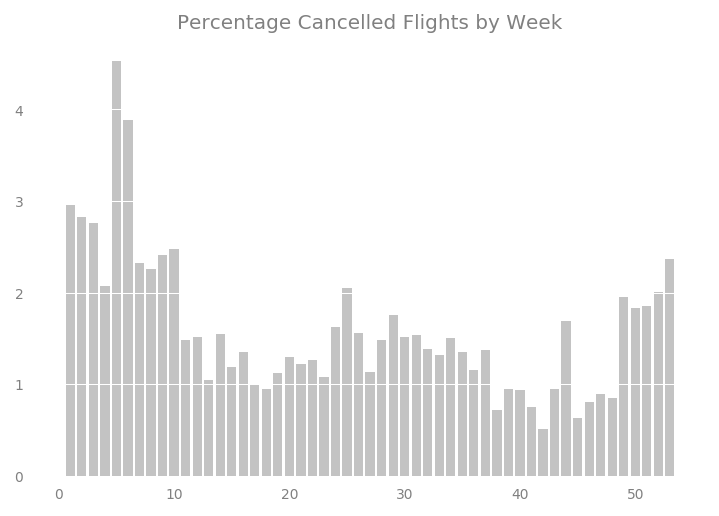

In [105]:
def plotter():
  sns.set_style("white",{'axes.axisbelow': False})
  plt.bar( 
    cancel_by_week_percent_pd.week, 
    cancel_by_week_percent_pd.delay_percent,
    align='center', 
    alpha=0.5,
    color='#888888',
  )
  plt.grid(color='#FFFFFF', linestyle='-', linewidth=0.5, axis='y')
  plt.title(
    'Percentage Cancelled Flights by Week',
    color='grey'
  )
  plt.xticks(
    color='grey'
  )
  plt.yticks(color='grey')
  sns.despine(left=True,bottom=True)
plotter()

In [106]:
## TIP Aggregation in the select if no groupby

all_routes = flight_df\
  .withColumn("combo_hash", hash("ORIGIN")+hash("DEST"))\
  .withColumn("combo", concat(col("ORIGIN"),col("DEST")))\
  .groupby("combo_hash")\
  .agg(count("combo_hash").alias("count_all"),first("combo").alias("route_alias_all"))\
  .sort("count_all",ascending=False)

cancelled_routes_all = flight_df\
  .filter("CANCELLED == 1")\
  .withColumn("combo_hash", hash("ORIGIN")+hash("DEST"))\
  .withColumn("combo", concat(col("ORIGIN"),col("DEST")))\
  .groupby("combo_hash")\
  .agg(count("combo_hash").alias("count"),first("combo").alias("route_alias"))\
  .sort("count",ascending=False)  

cancelled_routes_percentage = cancelled_routes_all\
  .join(
    all_routes,
    cancelled_routes_all.combo_hash == all_routes.combo_hash
  )\
  .withColumn(
    "route", 
    concat(
      substring(col("route_alias"),0,3),
      lit("<>"),
      substring(col("route_alias"),4,6)
    )
  )\
  .withColumn(
    "cancelled_percent", 
    col("count")/col("count_all")*100
  )\
  .select("route","count","count_all","cancelled_percent")\
  .sort("cancelled_percent",ascending=False)

display(cancelled_routes_percentage.toPandas().head(10))



route  count  count_all  cancelled_percent
0  LAN<>MBS      1          1              100.0
1  ALB<>MHT      1          1              100.0
2  SBP<>SMX      3          3              100.0
3  LBB<>ORD      1          1              100.0
4  EWR<>JFK      1          1              100.0
5  SDF<>BNA      1          1              100.0
6  COS<>OKC      1          1              100.0
7  HLN<>GTF      1          1              100.0
8  MFR<>EUG      2          2              100.0
9  BIS<>DVL      1          1              100.0

In [107]:
## Cancelled Routes Plotted on a Map

airports = spark.read.csv(
  path="s3a://ml-field/demo/flight-analysis/data/airports_orig.csv",
  header=True,
  inferSchema=True
)

cancelled_routes_combo = cancelled_routes_all

cancelled_routes_combo = cancelled_routes_combo\
  .withColumn("orig",substring(col("route_alias"),0,3))\
  .withColumn("dest",substring(col("route_alias"),4,6))

cancelled_routes_combo = cancelled_routes_combo\
  .join(
    airports,
    cancelled_routes_combo.orig == airports.iata
  )
  
cancelled_routes_combo = cancelled_routes_combo\
  .withColumnRenamed("lat","orig_lat")\
  .withColumnRenamed("long","orig_long")\
  .select("count","orig","dest","orig_lat","orig_long")
  
cancelled_routes_combo = cancelled_routes_combo\
  .join(
    airports,
    cancelled_routes_combo.dest == airports.iata
  )
  
cancelled_routes_combo = cancelled_routes_combo\
  .withColumnRenamed("lat","dest_lat")\
  .withColumnRenamed("long","dest_long")\
  .select("count","orig","dest","orig_lat","orig_long","dest_lat","dest_long")\
  .filter((col("orig_lat") > 20) & (col("orig_lat") < 50) & (col("count") > 500))


cancelled_routes_combo = cancelled_routes_combo.toPandas()

display(cancelled_routes_combo.head(10))

count orig dest   orig_lat   orig_long   dest_lat   dest_long
0   9881  BOS  LGA  42.364348  -71.005179  40.777243  -73.872609
1   8507  LGA  ORD  40.777243  -73.872609  41.979595  -87.904464
2   7686  LAX  SFO  33.942536 -118.408074  37.619002 -122.374843
3   6229  HOU  DAL  29.645419  -95.278889  32.847114  -96.851772
4   5775  DCA  LGA  38.852083  -77.037722  40.777243  -73.872609
5   5089  LGA  ATL  40.777243  -73.872609  33.640444  -84.426944
6   5005  BOS  DCA  42.364348  -71.005179  38.852083  -77.037722
7   4621  DCA  ORD  38.852083  -77.037722  41.979595  -87.904464
8   4449  EWR  ORD  40.692497  -74.168661  41.979595  -87.904464
9   3660  PHL  BOS  39.871953  -75.241141  42.364348  -71.005179

In [108]:
# !jupyter nbextension enable --py ipyleaflet

In [109]:
from ipyleaflet import Map
from IPython.display import display

m.add_layer(basemap_to_tiles(basemaps.CartoDB.Positron))
m = Map(center = (39.5, -98.3), zoom =4)
for i in range(len(cancelled_routes_combo.index)):
    m.add_layer(
        Polyline(
            locations= [[
                [[cancelled_routes_combo.iloc[i,3],cancelled_routes_combo.iloc[i,4]],
                 [cancelled_routes_combo.iloc[i,5],cancelled_routes_combo.iloc[i,6]]],]],
            color = "#888",
            weight = int(10*((int(cancelled_routes_combo.iloc[i,0])/9881)+0.1)),
            opacity = 0.8*((int(cancelled_routes_combo.iloc[i,0])/9881)+0.05)
        )
    )


display(m)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map â€¦